In [151]:
import numpy as np
import pandas as pd
from simulation import Simulation
import os
from matplotlib import pyplot as plt
from matplotlib import cm

In [52]:

beta2345_f = os.path.join("..","..","Output_SM","Betas","Beta_Estimates_2345.xlsx")
beta1_f = os.path.join("..","..","Output_SM","Betas","Beta_Estimates_1.xlsx")
beta2345_arr = pd.read_excel(beta2345_f).to_numpy()[:,2:].astype(np.float64)
beta1_arr = pd.read_excel(beta1_f).to_numpy()[:,2:].astype(np.float64)

In [53]:
person = np.array([[
    1, # one
    0, # previous never smoker
    0, # previous former smoker
    0, # previous nonmenthol smoker
    1, # previous menthol smoker
    0, # current former smoker
    0, # current nonmenthol smoker
    1, # current menthol smoker
    0, # initiation age grp = 1 (less than 18 years old)
    1, # initiation age grp = 2 (more than 18 years old)
    1, # black
    28, # age
    0, # sex (0 = male, 1 = female)
    0, # poverty (0 = not in poverty, 1 = in poverty)
    17, # start age (doesn't matter for the logistic regression model)
    100, # weight (doesn't matter for the logistic regression model)
    2015, # last year smoked
]])

In [54]:

def get_augmented_betas(beta2345, beta1):
    beta_2345_aug = np.concatenate([
        beta2345,
        np.zeros((len(beta2345), 3), dtype=np.float64),
    ], axis=1, dtype=np.float64)

    beta_1_aug = np.concatenate([
        beta1[:,0][:,np.newaxis],
        np.zeros((len(beta1), 9), dtype=np.float64),
        beta1[:,1:],
        np.zeros((len(beta1), 3), dtype=np.float64),
    ], axis=1, dtype=np.float64)

    beta_2345_aug = np.transpose(beta_2345_aug)
    beta_1_aug = np.transpose(beta_1_aug)

    return beta_2345_aug, beta_1_aug

In [55]:

def get_transition_probs_from_LR(in_arr2345, in_arr1, in_beta_2345_aug, in_beta_1_aug):
    
    logits_2345 = np.matmul(in_arr2345, in_beta_2345_aug).astype(np.float64)
    assert(logits_2345.shape[1] == 3)

    logits_1 = np.matmul(in_arr1, in_beta_1_aug).astype(np.float64)
    assert(logits_1.shape[1] == 4)

    # convert logits to probabilities

    exps = np.exp(logits_2345)
    p4 = 1 / (1 + np.sum(exps, axis=1))
    probs2345 = np.asarray([
        np.zeros(in_arr2345.shape[0]), # p1
        p4*exps[:,0], # p2
        p4*exps[:,1], # p3
        p4,           # p4
        p4*exps[:,2], # p5
    ], dtype=np.float64).transpose()

    exps = np.exp(logits_1)
    p4 = 1 / (1 + np.sum(exps, axis=1))
    probs1 = np.asarray([
        p4*exps[:,0], # p1
        p4*exps[:,1], # p2
        p4*exps[:,2], # p3
        p4,           # p4
        p4*exps[:,3], # p5
    ], dtype=np.float64).transpose()

    return probs2345, probs1

In [56]:

beta_2345_aug, beta_1_aug = get_augmented_betas(beta2345=beta2345_arr, beta1=beta1_arr)


In [57]:
probs = get_transition_probs_from_LR(in_arr2345=person, in_arr1=person, in_beta_1_aug=beta_1_aug, in_beta_2345_aug=beta_2345_aug)[0]
probs

array([[0.        , 0.10725122, 0.05815677, 0.77850804, 0.05608397]])

In [58]:
next_year = np.copy(person)
next_year[:,11] += 1 # age up
next_year = np.tile(next_year, (4,1))
next_year[:,5:9] = np.zeros_like(next_year[:,5:9])
next_year[0, 5] = 1
next_year[1, 6] = 1
next_year[2, 7] = 1
next_year


array([[   1,    0,    0,    0,    1,    1,    0,    0,    0,    1,    1,
          29,    0,    0,   17,  100, 2015],
       [   1,    0,    0,    0,    1,    0,    1,    0,    0,    1,    1,
          29,    0,    0,   17,  100, 2015],
       [   1,    0,    0,    0,    1,    0,    0,    1,    0,    1,    1,
          29,    0,    0,   17,  100, 2015],
       [   1,    0,    0,    0,    1,    0,    0,    0,    0,    1,    1,
          29,    0,    0,   17,  100, 2015]])

In [59]:
next_year_probs = get_transition_probs_from_LR(in_arr2345=next_year, in_arr1=next_year, in_beta_1_aug=beta_1_aug, in_beta_2345_aug=beta_2345_aug)[0]
next_year_probs

array([[0.        , 0.74004856, 0.067117  , 0.14465949, 0.04817495],
       [0.        , 0.09813256, 0.63462159, 0.18754851, 0.07969735],
       [0.        , 0.10775043, 0.05754634, 0.77978705, 0.05491618],
       [0.        , 0.12789827, 0.12630221, 0.23800489, 0.50779463]])

In [60]:
probs

array([[0.        , 0.10725122, 0.05815677, 0.77850804, 0.05608397]])

In [63]:
to_multiply = probs[0,1:]
to_multiply = np.tile(to_multiply, (5,1))
to_multiply = to_multiply.T
to_multiply.shape

array([[0.10725122, 0.10725122, 0.10725122, 0.10725122, 0.10725122],
       [0.05815677, 0.05815677, 0.05815677, 0.05815677, 0.05815677],
       [0.77850804, 0.77850804, 0.77850804, 0.77850804, 0.77850804],
       [0.05608397, 0.05608397, 0.05608397, 0.05608397, 0.05608397]])

In [68]:
result = next_year_probs * to_multiply
result = result[:,1:]
result

array([[0.07937111, 0.00719838, 0.01551491, 0.00516682],
       [0.00570707, 0.03690754, 0.01090722, 0.00463494],
       [0.08388458, 0.04480029, 0.60707049, 0.04275269],
       [0.00717304, 0.00708353, 0.01334826, 0.02847914]])

In [69]:
np.sum(result)

0.9999999999999998

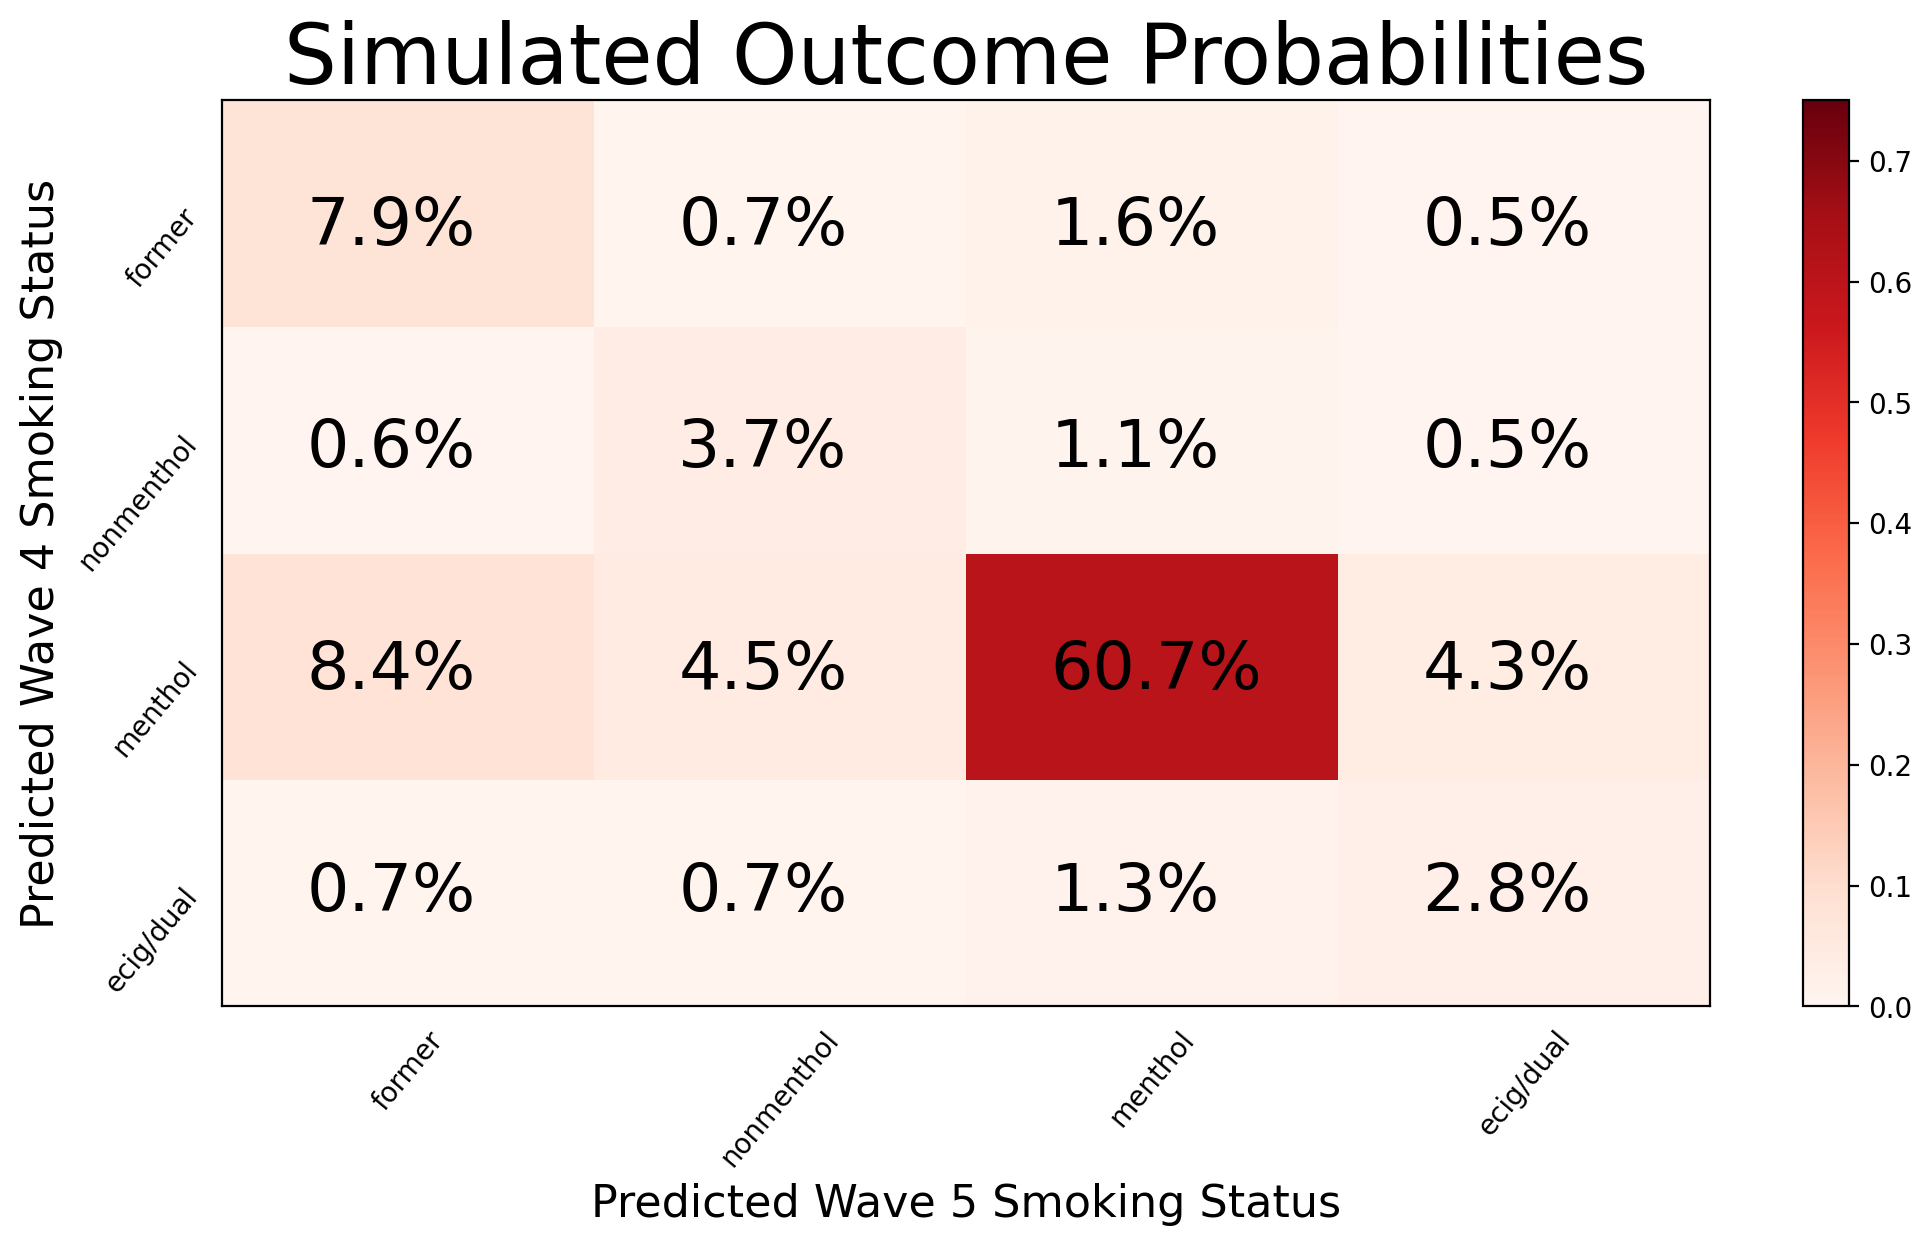

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=200)

c = ax.pcolor(result[::-1,:], vmin=0, vmax=0.75, cmap='Reds')

ax.set_title("Simulated Outcome Probabilities", fontsize=30)

fig.colorbar(c, ax=ax)

ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(["former", "nonmenthol", "menthol", "ecig/dual"])
ax.set_yticklabels(["former", "nonmenthol", "menthol", "ecig/dual"][::-1])

ax.tick_params(
    bottom=False,
    left=False,
)

plt.xlabel("Predicted Wave 5 Smoking Status", fontsize=16)
plt.ylabel("Predicted Wave 4 Smoking Status", fontsize=16)

ax.tick_params(rotation=50)

for i in range(len(result)):
    for j in range(len(result[i])):
        xcord = 0.16 + 0.155*j
        ycord = 0.76 - .185*i
        fig.text(xcord, ycord, f"{np.around(result[i,j] * 100, 1)}%", c='black', fontsize=24)

plt.show()